In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score


from catboost import CatBoostClassifier, Pool, metrics, cv

In [2]:
columns = ["status", # Attribute 1: Status of existing checking account
                     #  A11 : ... < 0DM
                     #  A12 : 0 <= ... < 200DM
                     #  A13:       ... >= 200DM / salary assignments for at least 1 year
                     #  A14: no checking account
           "duration", # Attribute 2: Duration in months
           "history",  # Attribute 3: Credit history
                       #    A30 : no credits taken / all credits paid back duly
                       #    A31 : all credits at this bank paid duly
                       #    A32 : existing credits paid back duly until now
                       #    A33 : delay in paying off in the past
                       #    A34 : critical account / other credits existing (not at this bank)
            "purpose", # Attribute 4: Purpose
                       #    A40 : car (new)
                       #    A41 : car (used)
                       #    A42 : furniture/equipment
                       #    A43 : radio/television
                       #    A44 : domestic appliances
                       #    A45 : repairs
                       #    A46 : education
                       #    A47 : (vacation -does not exist?)
                       #    A48 : retraining
                       #    A49 : business
                       #    A410 : others
            "amount",  # Attribute 5 : Credit amount
            "savings", # Attribute 6 : Savings account / bonds
            "employment", # Attribute 7 : Present employment since
                          #     A71 : unemployed
                          #     A72 : ... < 1 year
                          #     A73 : 1 <= ... < 4 years
                          #     A74 : 4 <= ... < 7 years
                          #     A75 :      ... >= 7 years
            "installment", # Attribute 8 : Installment rate in percentage of disposable income
            "sex", # Attribute 9 : Personal status and sex
                   #    A91 : male : divorced/separated
                   #    A92 : female : divorced/separated/married
                   #    A93 : male : single 
                   #    A94 : male : married/widowed
                   #    A95 : female : single
            "debtors", # Attributes 10 : Other debtors / guarantors
                       #    A101 : none
                       #    A102 : co-applicant
                       #    A103 : guarantor
            "residence", # Attributes 11 : Present residence since
            "property",  # Attribute 12 : Property
                         #  A121 : real estate
                         #  A122 : if not A121 : building society savings agreement/life insurance
                         #  A123 : if not A121/A122 : car or other, not in attribute 6
                         #  A124 : unknown / no property
            "age",       # Attribute 13 : age in years
            "plans",     # Attribute 14 : Other installment plans
                         #  A141 : bank
                         #  A142 : stores
                         #  A143 : none
            "housing",   # Attribute 15 : Housing
                         #  A151 : rent
                         #  A152 : own
                         #  A153 : for free
            "existing_credit", # Attribute 16 : Number of existing credits at this bank
            "job", # Attribute 17 : Job
                   #    A171 : unemployed/unskilled - non-resident
                   #    A172 : unskilled - resident
                   #    A173 : skilled employee / official
                   #    A174 : management/self-employed/highly qualified employee/officer
            "maintenance", # Attribute 18 : Number of people being liable to provide maintenance for
            "telephone", # Attribute 19 : Telephone
                         #  A191 : none
                         #  A192 : yes, registered under the customers name
            "foreign", # Attribute 20 : Foreign worker
                       #    A201 : yes
                       #    A202 : no 
           ]

In [3]:
df = pd.read_csv("index.csv")
categorical_features_indices = [0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18, 19]
# Get target variable
X = df.drop("Creditability", axis=1)
# Build sex column
X['Sex'] = 1
mask = (X["Sex & Marital Status"] == 2) | (X["Sex & Marital Status"] == 5)
X.loc[mask, 'Sex'] = 0
# Drop sex and marital status column
X = X.drop("Sex & Marital Status", axis=1)
y = df["Creditability"]
# Apply train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.6, random_state=42)

train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
val_pool = Pool(X_val, y_val, cat_features=categorical_features_indices)


In [4]:
X.columns

Index(['Account Balance', 'Duration of Credit (month)',
       'Payment Status of Previous Credit', 'Purpose', 'Credit Amount',
       'Value Savings/Stocks', 'Length of current employment',
       'Instalment per cent', 'Guarantors', 'Duration in Current address',
       'Most valuable available asset', 'Age (years)', 'Concurrent Credits',
       'Type of apartment', 'No of Credits at this Bank', 'Occupation',
       'No of dependents', 'Telephone', 'Foreign Worker', 'Sex'],
      dtype='object')

In [5]:
X['Payment Status of Previous Credit'].describe()

count    1000.00000
mean        2.54500
std         1.08312
min         0.00000
25%         2.00000
50%         2.00000
75%         4.00000
max         4.00000
Name: Payment Status of Previous Credit, dtype: float64

In [6]:
model = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=42,
    logging_level="Silent"
)

model.fit(X_train, y_train)
y_pred = model.predict(X_val)

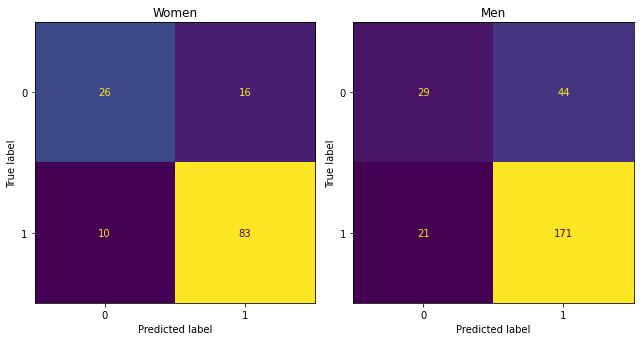

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(3*3, 5))
ConfusionMatrixDisplay.from_estimator(model, X_val[X_val['Sex'] == 0], y_val[X_val['Sex'] == 0], ax=ax1, colorbar=False)
ConfusionMatrixDisplay.from_estimator(model, X_val[X_val['Sex'] == 1], y_val[X_val['Sex'] == 1], ax=ax2, colorbar=False)
#ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, ax=ax3, colorbar=False)
ax1.set_title("Women")
ax2.set_title("Men")
plt.tight_layout()
plt.show()

In [19]:
def eval_fairness(y_pred, y_true, woman_mask, man_mask):
    y_pred_woman = y_pred[woman_mask]
    y_true_woman = y_true[woman_mask]
    y_pred_man = y_pred[man_mask]
    y_true_man = y_true[man_mask]
    # False Positive Rates FPR = FP / (FP + TN)
    fpr_woman = np.sum((y_pred_woman == 1) * (y_true_woman == 0)) / np.sum(y_true_woman == 0)
    fpr_man = np.sum((y_pred_man == 1) * (y_true_man == 0)) / np.sum(y_true_man == 0)
    # True positive rates TPR = TP / (TP + FN)
    tpr_woman = np.sum((y_pred_woman == 1)*(y_true_woman == 1)) / np.sum(y_true_woman == 1)
    tpr_man = np.sum((y_pred_man == 1)*(y_true_man == 1)) / np.sum(y_true_man == 1)
    # Precision
    precision_woman = precision_score(y_true_woman, y_pred_woman)
    precision_man = precision_score(y_true_man, y_pred_man)

    # Recall
    recall_woman = recall_score(y_true_woman, y_pred_woman)
    recall_man = recall_score(y_true_man, y_pred_man)


    data = {}
    data['TPR_man'] = tpr_man
    data['TPR_woman'] = tpr_woman
    data['FPR_man'] = fpr_man
    data['FPR_woman'] = fpr_woman
    data['precision_man'] = precision_man
    data['precision_woman'] = precision_woman
    data['recall_man'] = recall_man
    data['recall_woman'] = recall_woman
    data['Eq. Oportunity'] = abs(tpr_man-tpr_woman)
    data['Pred. Equality'] = abs(fpr_man-fpr_woman)
    data['Eq. odds'] = abs(tpr_man-tpr_woman) + abs(fpr_man-fpr_woman)
    data['Pred. Parity'] = abs(precision_man - precision_woman)
    data['Difference in recalls'] = abs(precision_man - precision_woman)
    data['Accuracy'] = np.mean(y_pred == y_true)
    
    return data 

In [20]:
woman_mask = X_val["Sex"] == 0
man_mask = X_val["Sex"] == 1

data = eval_fairness(y_pred, y_val, woman_mask, man_mask)
data

{'TPR_man': 0.890625,
 'TPR_woman': 0.8924731182795699,
 'FPR_man': 0.6027397260273972,
 'FPR_woman': 0.38095238095238093,
 'precision_man': 0.7953488372093023,
 'precision_woman': 0.8383838383838383,
 'recall_man': 0.890625,
 'recall_woman': 0.8924731182795699,
 'Eq. Oportunity': 0.001848118279569877,
 'Pred. Equality': 0.2217873450750163,
 'Eq. odds': 0.22363546335458617,
 'Pred. Parity': 0.04303500117453607,
 'Difference in recalls': 0.04303500117453607,
 'Accuracy': 0.7725}

In [15]:
model = CatBoostClassifier(iterations=50, random_seed=42, logging_level='Silent').fit(train_pool)
feature_importances = model.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

Account Balance: 19.07402638397142
Duration of Credit (month): 12.559266286522227
Purpose: 9.512633920992785
Payment Status of Previous Credit: 8.780775349104514
Instalment per cent: 7.468865878597038
Value Savings/Stocks: 5.645291174712302
Most valuable available asset: 5.513643019905672
Type of apartment: 5.290905811039854
Credit Amount: 5.146964495565941
Length of current employment: 4.2806993578008345
Occupation: 3.70332075398969
Sex: 2.3262912346833917
Guarantors: 2.2143967574748658
Duration in Current address: 2.083303091905649
Concurrent Credits: 1.6723757011546028
No of Credits at this Bank: 1.6152885253159432
Telephone: 1.4459731670607805
Foreign Worker: 0.8596570395446904
No of dependents: 0.8063220506578103
Age (years): 0.0


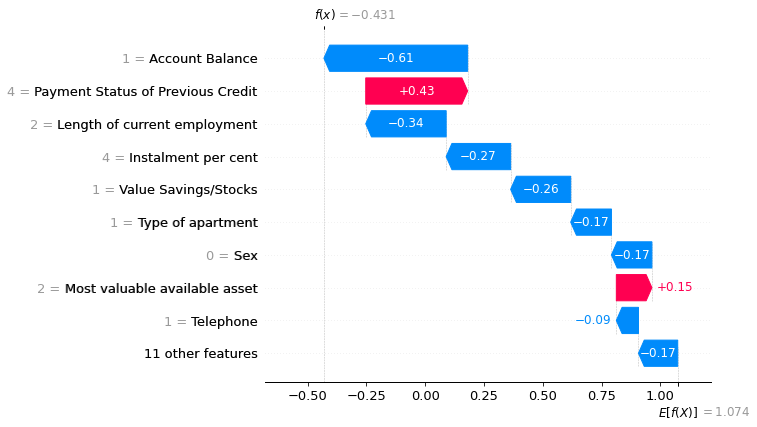

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

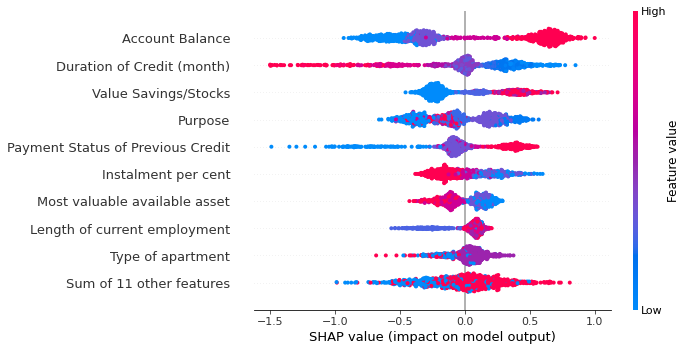

In [17]:
shap.plots.beeswarm(shap_values)